# Activity Recognition with Healthy Older People Using a Batteryless Wearable Sensor

This notebook provides code for loading the [activity recognition dataset](https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor) into a suitable format for classification and sequence labelling. 

The code is divided into three sections:
* Loading the data
* Sequence labelling: processing the data into a suitable format for sequence labelling. 
* Classification: processing the data into a suitable format for use with an IID classifier.

We recommend running all three sections, then using the variables produced by the code as required for sequence labelling and IID classification.


## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [2]:
import os

data_path = "../data/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [3]:
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [4]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [5]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

You may find the following code useful for creating a sequence labelling model:

In [6]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [7]:
# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

## IID Classification

In this code, we take the X and y lists produced for sequence labelling, and concatenate the data points for all sequences. This produces a single set of training data and a single set of test data, which are not divided into separate sequences.  

In [8]:
X_tr = np.concatenate(X_by_seq_tr, axis=0)  # combine features into one matrix -- use this as input features for training a classifier
y_tr = np.concatenate(y_by_seq_tr)  # combine target labels into one list -- use this as target labels for training a classifier

In [9]:
X_test = np.concatenate(X_by_seq_test, axis=0)  # combine features into one matrix -- use this as input features for testing a classifier
y_test = np.concatenate(y_by_seq_test)  # combine target labels into one list -- use this as target labels for evaluating a classifier

### Task 1: Neural Network Classifier

Train a neural network classifier
Import the necessary packages

In [60]:
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from numpy import int64
import random

from hmmlearn import hmm

In [16]:

# number of training exmaples
print(f'Number of training examples: {X_tr.shape}')
print(f'Number of training labels: {y_tr.shape}')
# number of test examples
print(f'Number of test examples: {X_test.shape}')
print(f'Number of test labels: {y_test.shape}')
# number of classes
print(f'Number of classes: {n_states}')
# normalise the data in the range of [0,1]
# X_tr = (X_tr - np.min(X_tr)) / (np.max(X_tr) - np.min(X_tr))
# X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

X_tr = minmax_scale(X_tr, feature_range=(0, 1), axis=0, copy=True)
X_test = minmax_scale(X_test, feature_range=(0, 1), axis=0, copy=True)
print(f'Train data Minimum value: {np.min(X_tr)}')
print(f'Train data Maximum value: {np.max(X_tr)}')
print(f'Test data Minimum value: {np.min(X_test)}')
print(f'Test data Maximum value: {np.max(X_test)}')

Number of training examples: (46509, 6)
Number of training labels: (46509,)
Number of test examples: (5973, 6)
Number of test labels: (5973,)
Number of classes: 4
Train data Minimum value: 0.0
Train data Maximum value: 1.0
Test data Minimum value: 0.0
Test data Maximum value: 1.0


In [17]:
nn_clf = MLPClassifier(hidden_layer_sizes=64,
                       activation='relu',
                       solver='sgd',
                       learning_rate_init=1e-3,
                       alpha=0,
                       max_iter=1000)
# train the model
nn_clf.fit(X_tr, y_tr)
# print the training and test accuracy
print(f'Training accuracy: {nn_clf.score(X_tr, y_tr)}')
print(f'Test accuracy: {nn_clf.score(X_test, y_test)}')

Training accuracy: 0.9116730095250382
Test accuracy: 0.8653942742340532


#### 1.(a): plot the learning curve
Using [learning_curve function](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py) from sklearn
For the learning curve, we use the accuracy as the scoring function, and we use 10-fold cross validation. We plot the learning curve for 5 different training sizes.

In [18]:
train_size, train_scores, test_scores, fit_times, _, = learning_curve(
    nn_clf, 
    X_tr, 
    y_tr, 
    cv=10, 
    scoring='accuracy',
    n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5), 
    return_times=True)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
fit_times_mean = np.mean(fit_times, axis=1)

print(f'Train scores: {train_scores_mean}')
print(f'Test scores: {test_scores_mean}')
print(f'Fit times: {fit_times_mean}')

train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
fit_times_std = np.std(fit_times, axis=1)

print(f'Train scores std: {train_scores_std}')
print(f'Test scores std: {test_scores_std}')
print(f'Fit times std: {fit_times_std}')


Train scores: [0.86501792 0.89161214 0.90302767 0.89861895 0.90437909]
Test scores: [0.87559424 0.89688003 0.89339683 0.89935274 0.89969678]
Fit times: [ 5.37301648  9.10609264 10.7408319  16.10978496 20.32333052]
Train scores std: [0.02387609 0.00965171 0.00657871 0.00484011 0.00394092]
Test scores std: [0.04591966 0.01664654 0.01517181 0.01556634 0.01719212]
Fit times std: [0.65274636 0.68550752 1.6162074  4.27891725 5.194434  ]


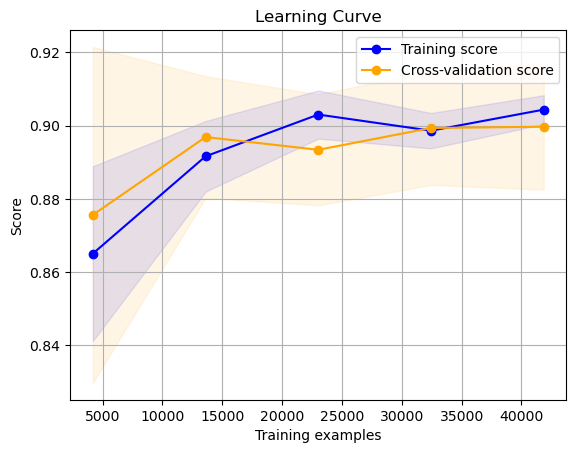

In [19]:
# plot the leaning and validation curve
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_size, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.1,
                 color='blue')
plt.fill_between(train_size,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='orange')
plt.plot(train_size, train_scores_mean, 'o-', color='blue', label='Training score')
plt.plot(train_size, test_scores_mean, 'o-', color='orange', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

We have 4 parameters in this trained data size :
   * train size
   * train score
   * test score
   * fit time
We can also plot the train_size & fit_time, which can help for analysing the model performance.
Moreover, we can plot the train_size & train_score, which can help for analysing the model bias.
Last, we can plot the train_size & test_score - train_score, which can help for analysing the model variance.


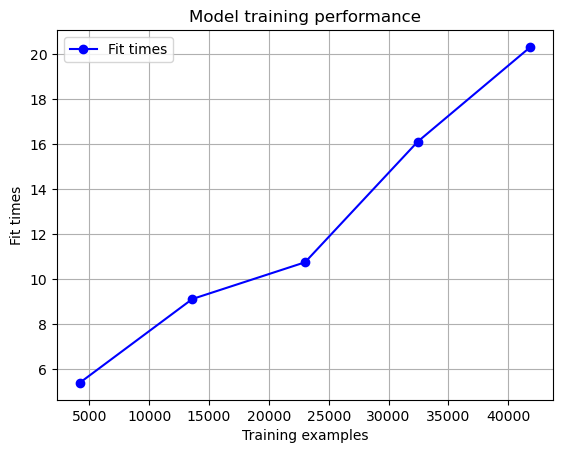

In [43]:
# plot the model performance, model bias and model variance
plt.figure()
plt.title('Model training performance')
plt.xlabel('Training examples')
plt.ylabel('Fit times')
plt.grid()
plt.plot(train_size, fit_times_mean, 'o-', color='blue', label='Fit times')
plt.legend(loc='best')
plt.show()

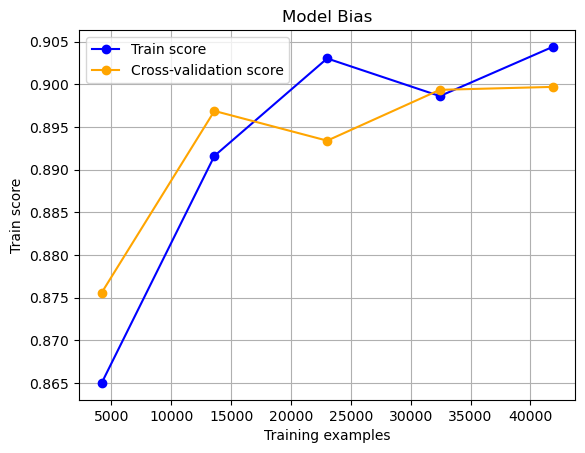

In [59]:
# plot the model bias
plt.figure()
plt.title('Model Bias')
plt.xlabel('Training examples')
plt.ylabel('Train score')
plt.grid()
plt.plot(train_size, train_scores_mean, 'o-', color='blue', label = 'Train score')
plt.plot(train_size, test_scores_mean, 'o-', color='orange', label = 'Cross-validation score')
plt.legend(loc='best')
plt.show()

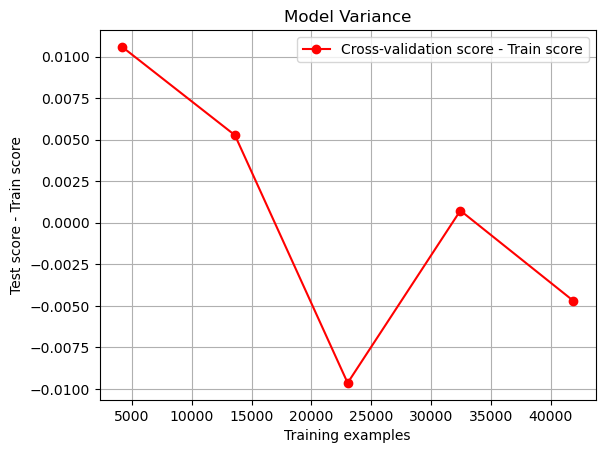

In [60]:
# plot the model variance
plt.figure()
plt.title('Model Variance')
plt.xlabel('Training examples')
plt.ylabel('Test score - Train score')
plt.grid()
plt.plot(train_size, test_scores_mean - train_scores_mean, 'o-', color='r', label = 'Cross-validation score - Train score')
plt.legend(loc='best')
plt.show()

#### 1.(b): plot the confusion matrix
Using [confusion_matrix function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) from sklearn
results on the test set:

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      2373
           1       0.14      0.10      0.11       388
           2       1.00      0.91      0.95      3034
           3       0.81      0.49      0.61       178

    accuracy                           0.87      5973
   macro avg       0.69      0.62      0.64      5973
weighted avg       0.86      0.87      0.86      5973


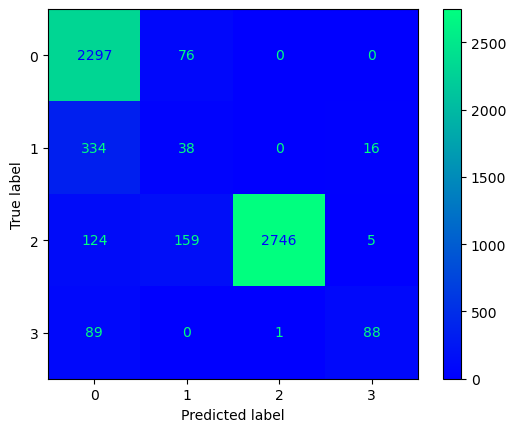

In [36]:
# plot the confusion matrix
cm = confusion_matrix(y_test, nn_clf.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix = cm).plot(cmap='winter')
pred_y = nn_clf.predict(X_test)
print(classification_report(y_test, pred_y))

#### 1.(c): Analysis the hyperparameters of the neural network classifier
1. hidden_layer_sizes: the number of hidden layers and the number of neurons in each hidden layer
2. activation: the activation function for the hidden layer
3. solver: the solver for weight optimization
4. learning_rate_init: the initial learning rate
5. alpha: the L2 penalty (regularization term) parameter
6. max_iter: the maximum number of iterations


In [41]:
# hidden_layer_sizes
hidden_layer_sizes = [2, 4, 8, 12, 16, 24, 48, 64, 128]
param ={'hidden_layer_sizes': hidden_layer_sizes}

nn_default = MLPClassifier(hidden_layer_sizes=64)
nn_clf_layer = GridSearchCV(nn_default, 
                      param, 
                      cv=10, 
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
nn_clf_layer.fit(X_tr, y_tr)
print(f'Best parameters: {nn_clf_layer.best_params_}')
print(f'Best score: {nn_clf_layer.best_score_}')

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best parameters: {'hidden_layer_sizes': 128}
Best score: 0.911801804676067


E:\envis\Anaconda3\envs\ml_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


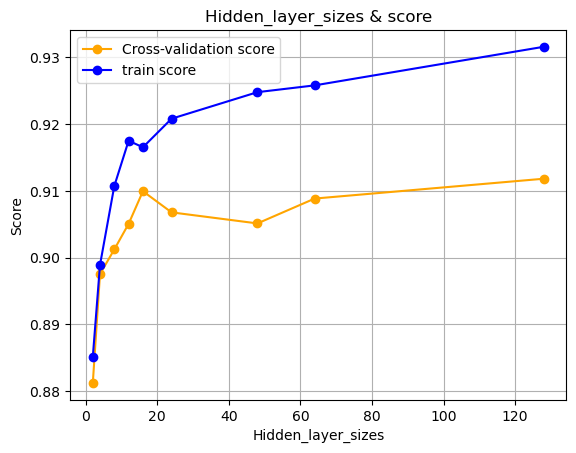

In [61]:
# plot the Hidden_layer_sizes & score
plt.figure()
plt.title('Hidden_layer_sizes & score')
plt.xlabel('Hidden_layer_sizes')
plt.ylabel('Score')
plt.grid()
plt.plot(hidden_layer_sizes, nn_clf_layer.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(hidden_layer_sizes, nn_clf_layer.cv_results_['mean_train_score'], 'o-', color='blue', label='train score')
plt.legend(loc='best')
plt.show()

In [46]:
# activation
activation = ['identity', 'logistic', 'tanh', 'relu']
param ={'activation': activation}

nn_default = MLPClassifier(hidden_layer_sizes=64)
nn_clf_act = GridSearchCV(nn_default, 
                      param, 
                      cv=10, 
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
nn_clf_act.fit(X_tr, y_tr)
print(f'Best parameters: {nn_clf_act.best_params_}')
print(f'Best score: {nn_clf_act.best_score_}')

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Best parameters: {'activation': 'relu'}
Best score: 0.9139948167003048


E:\envis\Anaconda3\envs\ml_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


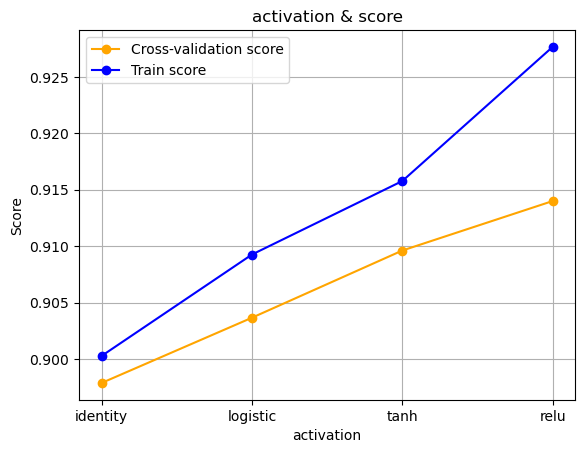

In [56]:
# plot the activation & score
plt.figure()
plt.title('activation & score')
plt.xlabel('activation')
plt.ylabel('Score')
plt.grid()
plt.plot(activation, nn_clf_act.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(activation, nn_clf_act.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()

In [48]:
# solver
solver = ['lbfgs', 'sgd', 'adam']
param ={'solver': solver}

nn_default = MLPClassifier(hidden_layer_sizes=64)
nn_clf_solver = GridSearchCV(nn_default, 
                      param, 
                      cv=10, 
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
nn_clf_solver.fit(X_tr, y_tr)
print(f'Best parameters: {nn_clf_solver.best_params_}')
print(f'Best score: {nn_clf_solver.best_score_}')

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Best parameters: {'solver': 'adam'}
Best score: 0.9106836869397956


E:\envis\Anaconda3\envs\ml_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


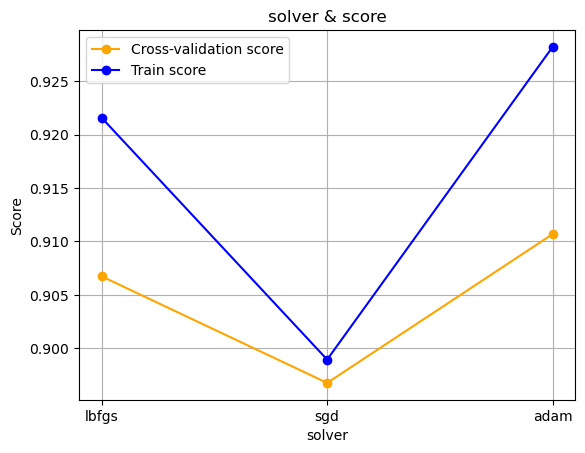

In [57]:
# plot the solver & score
plt.figure()
plt.title('solver & score')
plt.xlabel('solver')
plt.ylabel('Score')
plt.grid()
plt.plot(solver, nn_clf_solver.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(solver, nn_clf_solver.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()

In [50]:
# learning_rate_init
learning_rate_init = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
param ={'learning_rate_init': learning_rate_init}

nn_default = MLPClassifier(hidden_layer_sizes=64)
nn_clf_lr = GridSearchCV(nn_default, 
                      param, 
                      cv=10, 
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
nn_clf_lr.fit(X_tr, y_tr)
print(f'Best parameters: {nn_clf_lr.best_params_}')
print(f'Best score: {nn_clf_lr.best_score_}')

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best parameters: {'learning_rate_init': 0.01}
Best score: 0.9130273521938859


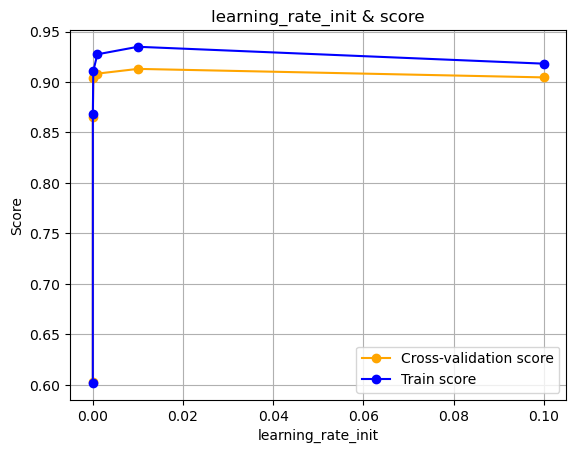

In [58]:
# plot the learning_rate_init & score
plt.figure()
plt.title('learning_rate_init & score')
plt.xlabel('learning_rate_init')
plt.ylabel('Score')
plt.grid()
plt.plot(learning_rate_init, nn_clf_lr.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(learning_rate_init, nn_clf_lr.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()

In [52]:
# alpha
alpha = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
param ={'alpha': alpha}

nn_default = MLPClassifier(hidden_layer_sizes=64)
nn_clf_alpha = GridSearchCV(nn_default, 
                      param, 
                      cv=10, 
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
nn_clf_alpha.fit(X_tr, y_tr)
print(f'Best parameters: {nn_clf_alpha.best_params_}')
print(f'Best score: {nn_clf_alpha.best_score_}')

Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best parameters: {'alpha': 1e-05}
Best score: 0.913285472195828


E:\envis\Anaconda3\envs\ml_env\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


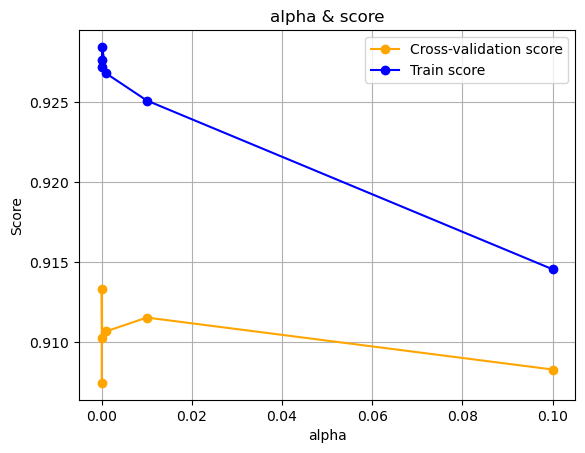

In [62]:
# plot the alpha & score
plt.figure()
plt.title('alpha & score')
plt.xlabel('alpha')
plt.ylabel('Score')
plt.grid()
plt.plot(alpha, nn_clf_alpha.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(alpha, nn_clf_alpha.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()

In [54]:
# max_iter
max_iter = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
param ={'max_iter': max_iter}

nn_default = MLPClassifier(hidden_layer_sizes=64)
nn_clf_iter = GridSearchCV(nn_default, 
                      param, 
                      cv=10, 
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
nn_clf_iter.fit(X_tr, y_tr)
print(f'Best parameters: {nn_clf_iter.best_params_}')
print(f'Best score: {nn_clf_iter.best_score_}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'max_iter': 1000}
Best score: 0.911457912854907


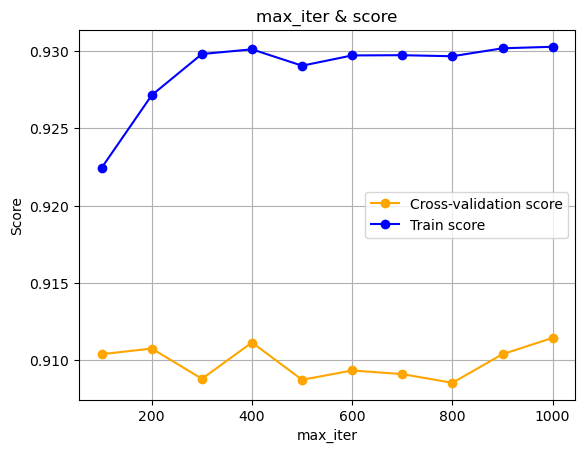

In [63]:
# plot the max_iter & score
plt.figure()
plt.title('max_iter & score')
plt.xlabel('max_iter')
plt.ylabel('Score')
plt.grid()
plt.plot(max_iter, nn_clf_iter.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(max_iter, nn_clf_iter.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()

Combine all the best hyperparameters together
Compare the performance of the model we used before and the best model

In [64]:
# the best model
nn_clf_best = MLPClassifier(hidden_layer_sizes=32,
                       activation='relu',
                       solver='adam',
                       learning_rate_init=0.01,
                       alpha=0.01,
                       max_iter=600)
nn_clf_best.fit(X_tr, y_tr)
print(f'Training accuracy: {nn_clf_best.score(X_tr, y_tr)}')
print(f'Test accuracy: {nn_clf_best.score(X_test, y_test)}')

Training accuracy: 0.9271968866240943
Test accuracy: 0.6911099949773983


### Task 2: Ensemble decision tree

 2.(a): Training a Decision Tree Classifier
 

In [49]:
model = DecisionTreeClassifier()
model.fit(X_tr, y_tr)
train_accuracy = model.score(X_tr, y_tr)
test_accuracy = model.score(X_test, y_test)
print(f'Training accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}')

Training accuracy: 0.9999354963555441
Test accuracy: 0.8355935041017913


2.(a): Train an ensemble of decision trees
[AdaBoost algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn-ensemble-adaboostclassifier)

In [15]:
from sklearn.ensemble import AdaBoostClassifier

model = DecisionTreeClassifier(max_depth=10)
reg = AdaBoostClassifier(estimator=model, n_estimators=1000, random_state=0).fit(X_tr, y_tr)
boosting_train_accuracy = reg.score(X_tr, y_tr)
boosting_test_accuracy = reg.score(X_test, y_test)
print(f'Training accuracy: {boosting_train_accuracy}')
print(f'Test accuracy: {boosting_test_accuracy}')

Training accuracy: 0.9998279902814509
Test accuracy: 0.9060773480662984


#### 2.(b): Results on the test set, plot the confusion matrix for the test set

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2373
           1       0.38      0.37      0.37       388
           2       1.00      1.00      1.00      3034
           3       0.82      0.54      0.65       178

    accuracy                           0.90      5973
   macro avg       0.77      0.70      0.73      5973
weighted avg       0.90      0.90      0.90      5973


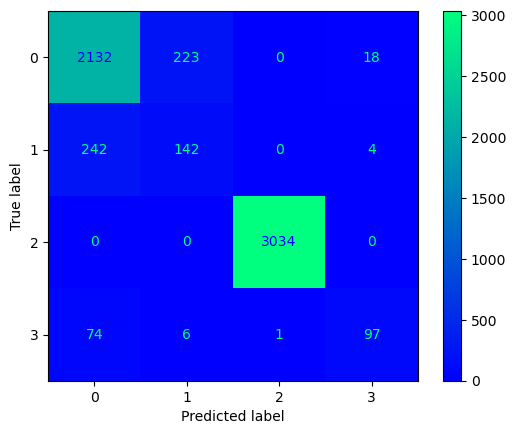

In [13]:
cm = confusion_matrix(y_test, reg.predict(X_test))
ConfusionMatrixDisplay(confusion_matrix = cm).plot(cmap='winter')
pred_y = reg.predict(X_test)
print(classification_report(y_test, pred_y))

#### 2.(c): Relationship between the error rate of the ensemble, the error rate of individual base models, and the number of base models.

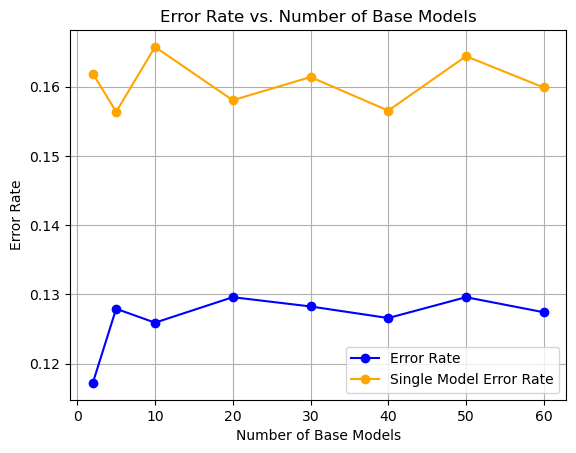

In [23]:
# plot the error rate of the ensemble, the error rate of individual base models, and the number of base models
num_models_test = [2, 5, 10, 20, 30, 40, 50, 60] # number of base classifiers
error = [] # error rate of the ensemble
single_model_error = [] # error rate of individual base models

for num_models in num_models_test:
    model = DecisionTreeClassifier().fit(X_tr, y_tr)
    single_model_error.append(1 - model.score(X_test, y_test))
    
    reg = AdaBoostClassifier(estimator=model, n_estimators=num_models).fit(X_tr, y_tr)
    test_accuracy.append(reg.score(X_test, y_test))
    error.append(1 - reg.score(X_test, y_test))
    
# plotting the results
plt.figure()
plt.title('Error Rate vs. Number of Base Models')
plt.xlabel('Number of Base Models')
plt.ylabel('Error Rate')
plt.grid()
plt.plot(num_models_test, error, 'o-', color='blue', label='Error Rate')
plt.plot(num_models_test, single_model_error, 'o-', color='orange', label='Single Model Error Rate')
plt.legend(loc='best')
plt.show()


#### 2.(d): The hyperparameters of the decision tree classifier
2.(d).1 max_depth: The maximum depth of the tree.

In [10]:
# For the basic decision tree classifier, we can use the GridSearchCV to find the best hyperparameters
param = {'max_depth': np.arange(1, 40)}
dt_default = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt_default, 
                      param,  
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
dt_clf.fit(X_tr, y_tr)
print(f'Best parameters: {dt_clf.best_params_}')
print(f'Best score: {dt_clf.best_score_}')

Fitting 5 folds for each of 39 candidates, totalling 195 fits
Best parameters: {'max_depth': 7}
Best score: 0.9067273013624394


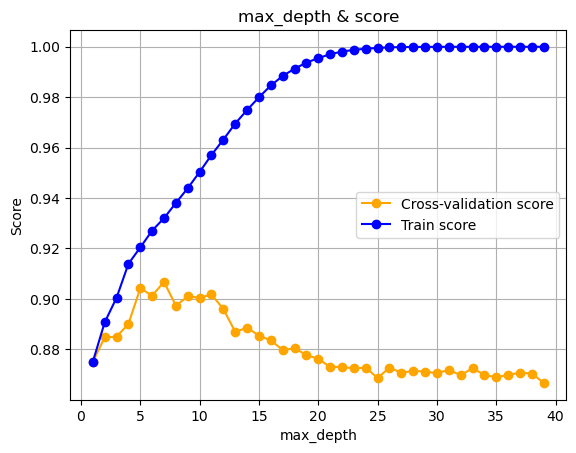

In [11]:
# plot the max_depth & score
plt.figure()
plt.title('max_depth & score')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.grid()
plt.plot(param['max_depth'], dt_clf.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(param['max_depth'], dt_clf.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()


2.(d).2: min_samples_split: The minimum number of samples required to split an internal node

In [34]:
param = {'min_samples_split': np.arange(2, 50)}
dt_default = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt_default, 
                      param,  
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
dt_clf.fit(X_tr, y_tr)
print(f'Best parameters: {dt_clf.best_params_}')
print(f'Best score: {dt_clf.best_score_}')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'min_samples_split': 43}
Best score: 0.8879357892890191


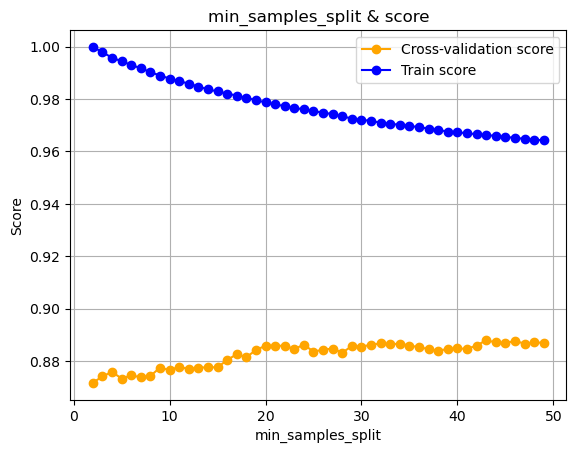

In [35]:
# plot the min_samples_split & score
plt.figure()
plt.title('min_samples_split & score')
plt.xlabel('min_samples_split')
plt.ylabel('Score')
plt.grid()
plt.plot(param['min_samples_split'], dt_clf.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(param['min_samples_split'], dt_clf.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()

2.(d).3: min_samples_leaf: The minimum number of samples required to be at a leaf node

In [36]:
param = {'min_samples_leaf': np.arange(1, 50)}
dt_default = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt_default, 
                      param,  
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
dt_clf.fit(X_tr, y_tr)
print(f'Best parameters: {dt_clf.best_params_}')
print(f'Best score: {dt_clf.best_score_}')

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Best parameters: {'min_samples_leaf': 41}
Best score: 0.9036315351243722


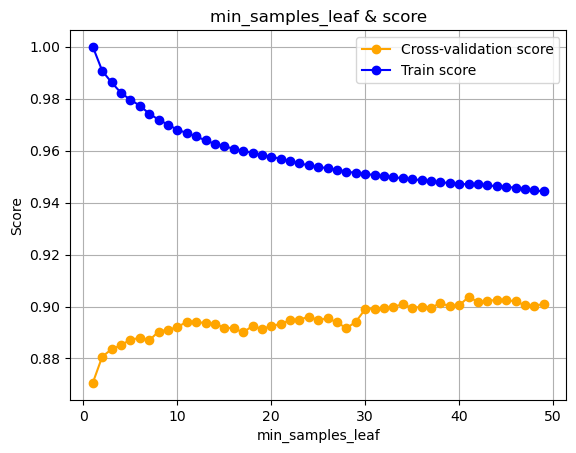

In [37]:
#plot the min_samples_leaf & score
plt.figure()
plt.title('min_samples_leaf & score')
plt.xlabel('min_samples_leaf')
plt.ylabel('Score')
plt.grid()
plt.plot(param['min_samples_leaf'], dt_clf.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(param['min_samples_leaf'], dt_clf.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()

2.(d).4: max_features: The number of features to consider when looking for the best split

In [40]:
param = {'max_features': np.arange(1, 10)}
dt_default = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt_default, 
                      param,  
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
dt_clf.fit(X_tr, y_tr)
print(f'Best parameters: {dt_clf.best_params_}')
print(f'Best score: {dt_clf.best_score_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'max_features': 3}
Best score: 0.8746907593760189


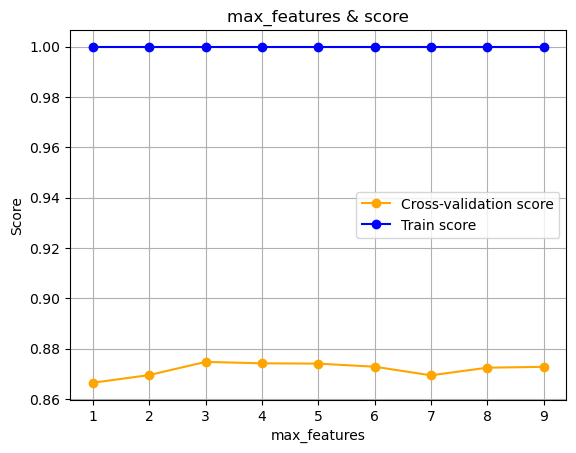

In [41]:
# plot the max_features & score
plt.figure()
plt.title('max_features & score')
plt.xlabel('max_features')
plt.ylabel('Score')
plt.grid()
plt.plot(param['max_features'], dt_clf.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(param['max_features'], dt_clf.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()

2.(d).5: criterion: The function to measure the quality of a split

In [50]:
param = {'criterion': ['gini', 'entropy','log_loss']}
dt_default = DecisionTreeClassifier()
dt_clf = GridSearchCV(dt_default, 
                      param,  
                      scoring='accuracy',
                      n_jobs=-1, 
                      verbose=2,
                      return_train_score=True)
dt_clf.fit(X_tr, y_tr)
print(f'Best parameters: {dt_clf.best_params_}')
print(f'Best score: {dt_clf.best_score_}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'criterion': 'gini'}
Best score: 0.8721320796706328


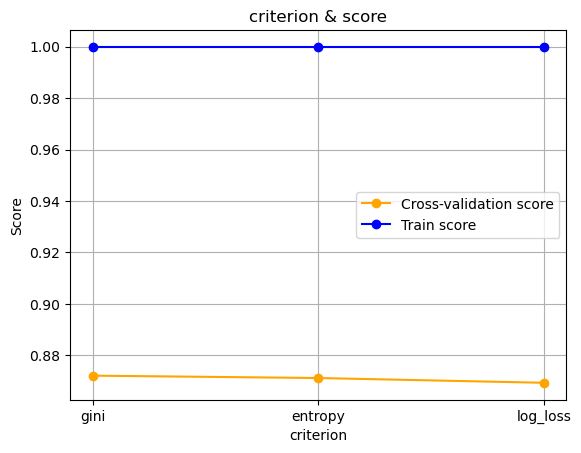

In [51]:
# plot the criterion & score
plt.figure()
plt.title('criterion & score')
plt.xlabel('criterion')
plt.ylabel('Score')
plt.grid()
plt.plot(param['criterion'], dt_clf.cv_results_['mean_test_score'], 'o-', color='orange', label='Cross-validation score')
plt.plot(param['criterion'], dt_clf.cv_results_['mean_train_score'], 'o-', color='blue', label='Train score')
plt.legend(loc='best')
plt.show()

### Task 3: Sequence labelling data
label each sequence of observations, taking their order into account
3.(a): Train a sequence labeller 
Using [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html) to train a sequence labeller

In [113]:
print(f'Number of training examples: {len(X_by_seq_tr)}')
print(f'Number of training labels: {len(y_by_seq_tr)}')
print(f'Number of test examples: {len(X_by_seq_test)}')
print(f'Number of test labels: {len(y_by_seq_test)}')
print(f'Number of classes: {n_states}')

print(len(X_by_seq_tr[1]))
print(len(y_by_seq_tr[2]))
print(X_by_seq_tr[1].shape)

Number of training examples: 48
Number of training labels: 48
Number of test examples: 12
Number of test labels: 12
Number of classes: 4
22
136
(22, 6)


In [118]:
lengths_tr = [len(seq) for seq in X_by_seq_tr]
lengths_test = [len(seq) for seq in X_by_seq_test]

hmm_model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000)
hmm_model.fit(np.concatenate(X_by_seq_tr, axis=0), lengths=lengths_tr)
test_score = hmm_model.score(np.concatenate(X_by_seq_test, axis=0), lengths=lengths_test)
print(f"Model Score on Test Data: {test_score}")

Model Score on Test Data: -33295.86596630188


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'
Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
Even though the 'means_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'm'
Even though the 'covars_' attribute is set, it will be overwritten during initialization because 'init_params' contains 'c'


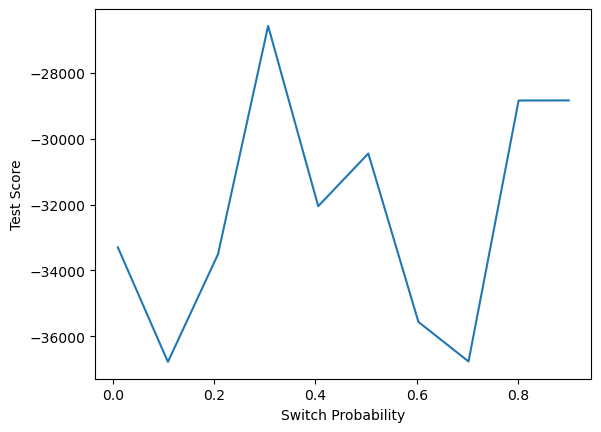

Best Switch Probability: 0.30666666666666664
Best Score: -26575.341377183366


In [114]:
np.random.seed(42)
best_score = float('-inf')
best_switch_prob = None
scores = []

switch_probs = np.linspace(0.01, 0.9, 10)
startprob = np.array([1.0 / n_states] * n_states)

for switch_prob in switch_probs:
    transmat = np.full((n_states, n_states), switch_prob)
    np.fill_diagonal(transmat, 1 - switch_prob * (n_states - 1))

    model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000)
    model.startprob_ = startprob
    model.transmat_ = transmat
    model.means_ = means
    model.covars_ = diagonal_covars
    model.fit(X_tr, lengths=[len(seq) for seq in X_by_seq_tr])

    score = model.score(X_test, lengths=[len(seq) for seq in X_by_seq_test])
    scores.append(score)

    if score > best_score:
        best_score = score
        best_switch_prob = switch_prob

plt.plot(switch_probs, scores)
plt.xlabel('Switch Probability')
plt.ylabel('Test Score')
plt.show()

print(f"Best Switch Probability: {best_switch_prob}")
print(f"Best Score: {best_score}")

In [117]:
# Create a HMM model
np.random.seed(42)
model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000,init_params='',params='stmc')
switch_prob = 0.30666666666666664
model.startprob_ = startprob
model.transmat_ = np.full((n_states, n_states), switch_prob)
np.fill_diagonal(model.transmat_, 1 - switch_prob * (n_states - 1))
model.means_ = means
model.covars_ = diagonal_covars

model.fit(X_tr, lengths=[len(seq) for seq in X_by_seq_tr])
score = model.score(np.concatenate(X_by_seq_test, axis=0), lengths=[len(seq) for seq in X_by_seq_test])

print(f"Model Score on Test Data: {score}")

Model Score on Test Data: -30137.086113478555


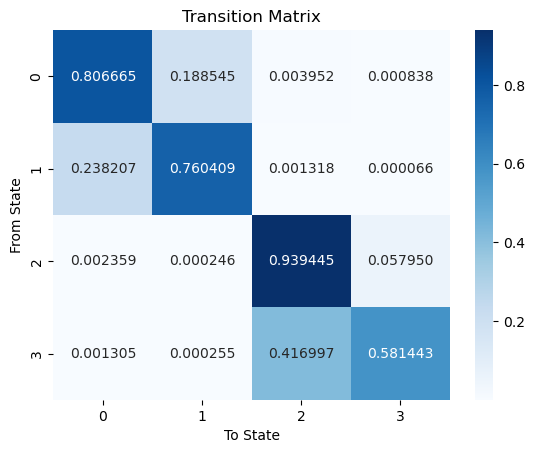

In [112]:
import seaborn as sns

transmat = model.transmat_

plt.figure()
sns.heatmap(transmat, annot=True, cmap='Blues', fmt='.6f' )
plt.title('Transition Matrix')
plt.xlabel('To State')
plt.ylabel('From State')
plt.show()